In [10]:
import pandas as pd

url = 'https://drive.google.com/uc?id=1rzRwxm_CJxcRzfoo9Ix37A2JTlMummY-'
df = pd.read_csv(url)

print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [ ]:

df = df[df['CustomerID'].notnull()]

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.shape


(397884, 9)

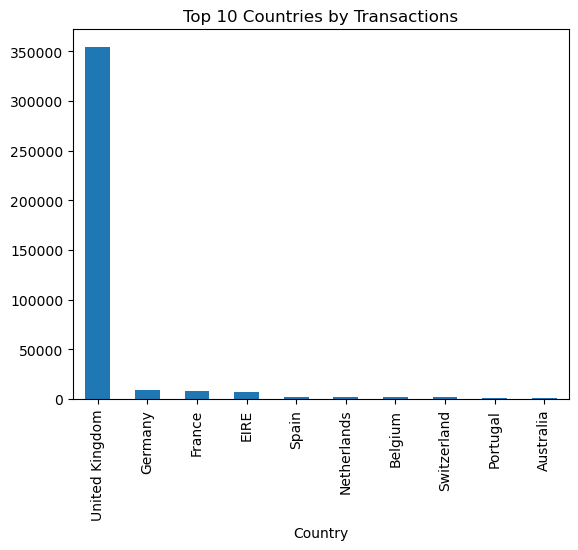

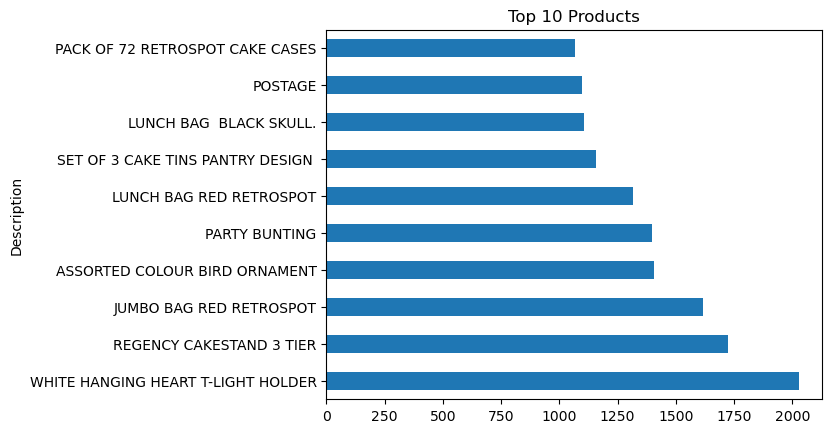

C:\Users\Asus\AppData\Local\Temp\ipykernel_17128\3557950626.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('InvoiceDate').resample('M')['InvoiceNo'].nunique().plot()


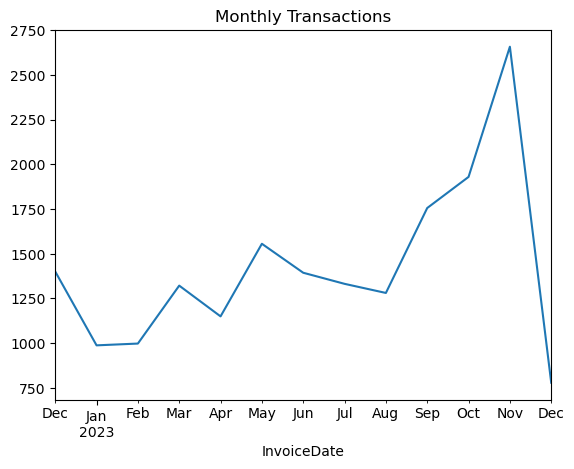

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Transactions")
plt.show()


df['Description'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 Products")
plt.show()

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate').resample('M')['InvoiceNo'].nunique().plot()
plt.title("Monthly Transactions")
plt.show()


In [14]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


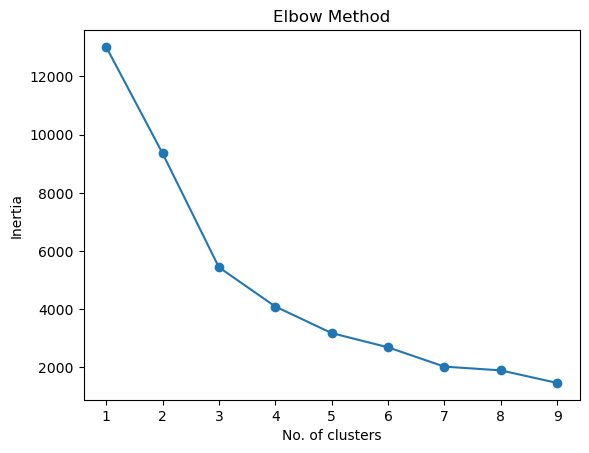

,Recency,Frequency,Monetary
Cluster,,,
0,40.984525,4.822346,2053.199654
1,7.666667,42.833333,190863.461667
2,246.023788,1.582800,631.141410
3,6.500000,120.500000,55312.686250


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of clusters')
plt.ylabel('Inertia')
plt.show()


kmeans = KMeans(n_clusters=4)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.groupby('Cluster').mean()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

user_item = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)

similarity_matrix = cosine_similarity(user_item.T)

similarity_df = pd.DataFrame(similarity_matrix, index=user_item.columns, columns=user_item.columns)

def recommend_items(item_code, n=5):
    similar_items = similarity_df[item_code].sort_values(ascending=False)[1:n+1]
    return similar_items

recommend_items('85099B') 

StockCode
85099F    0.902065
22386     0.897376
20713     0.801284
21929     0.788641
21928     0.771490
Name: 85099B, dtype: float64

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle


st.set_page_config(page_title="Shopper Spectrum", layout="centered")
st.title("🛒 Shopper Spectrum")
st.subheader("A Simple Tool for Product Recommendations & Customer Segmentation")
option = st.radio("Choose what you want to do:", ["🔍 Recommend Products", "👥 Segment Customer"])

